In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project3.ipynb")

<img style="display: block; margin-left: auto; margin-right: auto" src="./ccsf-logo.png" width="250rem;" alt="The CCSF black and white logo">

# Project 3: Movie Classification

In this project, you will build a classification model that guesses whether a movie is a comedy or a thriller by using only the number of times chosen words appear in the movie's screenplay. By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

## 🎗️ Reminders

* **Canvas Assignment Details**. View the related <a href="https://ccsf.instructure.com" target="_blank">Canvas</a> Assignment page for additional details such as the assignment rubric and due dates.
* **Auto-Grader.** Make sure to run the code cell at the top of this notebook that starts with `# Initialize Otter` to load the auto-grader.
* **[Optional] Project Partner.** 
    * For this assignment, you are allowed to complete this project with a partner, but you are not required to work with a partner.
    * If you want to work with someone, you and your partner should set up a Canvas group with your instructor for this assignment.
    * Keep in mind that for group assignments, one submission will count for the entire group in Canvas.
    * You and your partner will receive the same grade for this project.
* **Code Sharing.** Don't share your code directly with anybody but your partner. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for our exams and potentially for future work in this field. If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem or you can focus on a specific part of a task.
* **Support.** You are not alone! Meet with your instructor or the tutors, post questions on Canvas or the student Discord channel, and talk to your classmates during our meetings. If you're ever feeling overwhelmed or don't know how to make progress, talk to your instructor or a tutor.
* **Tests.** The tests that are given are **not comprehensive** and passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work! You might want to create your own checks along the way to see if your answers make sense. Additionally, before you submit, make sure that none of your cells take a very long time to run (several minutes).
* **Open Response Tasks:** Make sure that you put the answers to the written questions in the indicated cell we provide and generate the graphs as requested. Usually, the point number for the open response tasks corresponds to the number of things you need to address in your response.
* **Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Make sure that you are using distinct and meaningful variable names throughout the notebook. Along that line, **DO NOT** reuse the variable names that we use when we grade your answers. For example, in the first task, we ask you to assign an answer to `latest`. Do not reassign the variable name `latest` to anything else in your notebook, otherwise there is the chance that our tests grade against what `latest` was reassigned to.
* You are never expected to use just one line in this project or any others. Use intermediate variables and multiple lines as much as you would like! 

Run the following cell to get and import the relevant tools.

In [2]:
import datascience
import statsmodels
import math
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

## 💾 Part 1: The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [3]:
movies = Table.read_table('movies.csv')

Here is one row of the table and some of the frequencies of words that were said in the movie.

In [4]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

Additional context: This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. This is a model that is often used in [NLP](https://en.wikipedia.org/wiki/Natural_language_processing). A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. 

In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [5]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story');

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [6]:
row_for_title('toy story').item('fun') 

0.00034855350296270001

#### Task 1.1 📍

Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns. Think about what any one row adds up to.

_Points:_ 2

In [7]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [8]:
grader.check("task_1_1")

task_1_1 results: All test cases passed!
task_1_1 - 1 message: ✅ expected_row_sum is greater than 0.

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [9]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


### Section 1.1: Word Stemming

The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table called `vocab_table` that will let you see examples of unstemmed versions of each stemmed word. Run the code below to load it.

**Note:** You should use `vocab_table` for the rest of Section 1.1, not `vocab_mapping`. 

In [10]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Task 1.1.1 📍

Using `vocab_table`, find the stemmed version of the word "elements" and assign the value to `stemmed_message`.


_Points:_ 3

In [ ]:
stemmed_message = ...
stemmed_message

In [11]:
stemmed_message = vocab_table.where('Word', 'elements').column('Stem').item(0)
stemmed_message

'element'

In [12]:
grader.check("task_1_1_1")

task_1_1_1 results: All test cases passed!
task_1_1_1 - 1 message: ✅ stemmed_message is a string.
task_1_1_1 - 2 message: ✅ The length of stemmed_message is less than the lenght of 'elements'.

#### Task 1.1.2 📍

What stem in the dataset has the most words that are associated to it? Assign `most_stem` to that stem. 

_Points:_ 2

In [ ]:
most_stem = ...
most_stem

In [13]:
stem_counts = vocab_table.group('Stem')
most_stem = stem_counts.sort('count', descending=True).column('Stem').item(0)
most_stem

'gener'

In [14]:
grader.check("task_1_1_2")

task_1_1_2 results: All test cases passed!
task_1_1_2 - 1 message: ✅ most_stem is a string.

#### Task 1.1.3 📍

What is the longest word in the dataset that wasn't shortened to its stem? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "cat" or "bat", you should pick "cat"). Note that when sorting letters, the letter `a` is smaller than the letter `z`.

*Hint 1:* `vocab_table` has 2 columns: one for stems and one for the unstemmed (normal) word. Find the longest word that wasn't cut at all (same length as stem).

*Hint 2:* There is a table function that allows you to compute a function on every element in a column. Check [Python Reference](http://data8.org/sp22/python-reference.html) if you aren't sure which one.

*Hint 3:* Check the comments in the cell below if you are stuck.

_Points:_ 2

In [ ]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

tbl_with_lens = ...
tbl_with_diff = ...

longest_uncut = ...
longest_uncut

In [15]:
tbl_with_lens = vocab_table.with_columns(
    'Word Length', vocab_table.apply(len, 'Word'),
    'Stem Length', vocab_table.apply(len, 'Stem')
)

tbl_with_diff = tbl_with_lens.with_column('Length Difference', tbl_with_lens.column('Word Length') - tbl_with_lens.column('Stem Length'))
uncut_words = tbl_with_diff.where('Length Difference', are.equal_to(0))
longest_uncut = uncut_words.sort('Word Length', descending=True).sort('Word', descending=True).column('Word').item(0)
longest_uncut


'zoo'

In [16]:
grader.check("task_1_1_3")

task_1_1_3 results: All test cases passed!
task_1_1_3 - 1 message: ✅ longest_uncut is a string.

#### Task 1.1.4 📍

How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

Assign `count_single_stems` to the count of stems that map to one word only. 

_Points:_ 2

In [ ]:
count_single_stems = ...
count_single_stems

In [17]:
stem_counts = vocab_table.group('Stem')
count_single_stems = np.count_nonzero(stem_counts.column('count') == 1)
count_single_stems


1408

In [18]:
grader.check("task_1_1_4")

task_1_1_4 results: All test cases passed!
task_1_1_4 - 1 message: ✅ count_single_stems is an integer.

### Section 1.2: Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we’ll use the associated proportions to investigate the relationship between different words.

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of "space" proportions vs "outer" proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

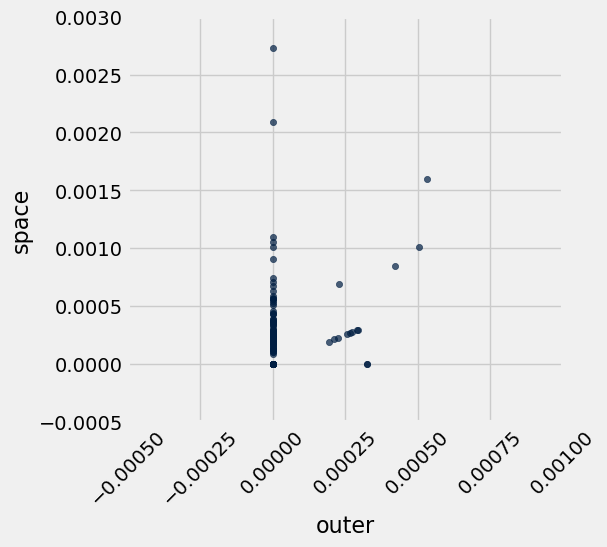

In [20]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plt.axis([-0.0005, 0.001, -0.0005, 0.003]);
plt.xticks(rotation=45);

#### Task 1.2.1 📍

Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`. 

*Hint:* If you need a refresher on how to calculate the correlation coefficient check out [Ch 15.1](https://inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r).

_Points:_ 2

In [ ]:
# These two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")

outer_su = ...
space_su = ...

outer_space_r = ...
outer_space_r

In [21]:
# These two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.mean(outer)) / np.std(outer)
space_su = (space - np.mean(space)) / np.std(space)

outer_space_r = np.mean(outer_su * space_su)
outer_space_r

0.31942607876895912

In [22]:
grader.check("task_1_2_1")

task_1_2_1 results: All test cases passed!
task_1_2_1 - 1 message: ✅ outer_space_r is between 0.2 and 0.4.

#### Task 1.2.2 📍🔎

<!-- BEGIN QUESTION -->

Choose two *different* words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. Please do not pick "outer" and "space" or "san" and "francisco". The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`. 

*Hint 1:* It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*. Try to think of common phrases or idioms.

*Hint 2:* Refer to [Section 15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#units-of-measurement-of-the-slope) of the textbook for the formulas. 

_Points:_ 2

In [ ]:
word_x = ...
word_y = ...

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = ...
y_su = ...

r = ...

slope = ...
intercept = ...

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plt.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plt.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

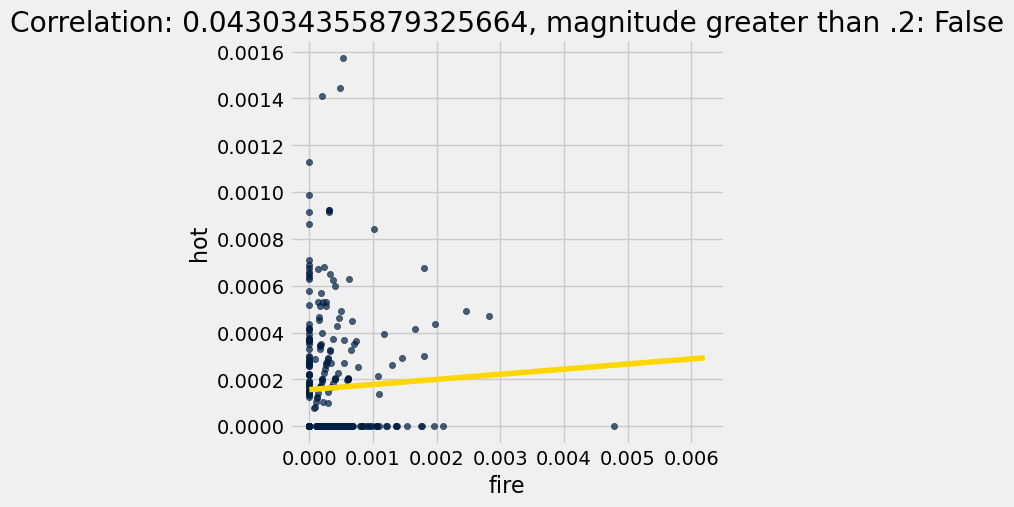

In [23]:
word_x = "fire"
word_y = "hot"

arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.mean(arr_x)) / np.std(arr_x)
y_su = (arr_y - np.mean(arr_y)) / np.std(arr_y)

r = np.mean(x_su * y_su)

slope = r * (np.std(arr_y) / np.std(arr_x))
intercept = np.mean(arr_y) - slope * np.mean(arr_x)

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plt.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plt.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');


<!-- END QUESTION -->

#### Task 1.2.3 📍

Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco. Assign `san_francisco` to either the number 1 or the number 2 according to which statement is true regarding the correlation between "san" and "francisco." 

1. "san" can also preceed other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."
2. "san" can also preceed other city names like San Diego and San Jose. The fact that "san" could appear more often in front of different cities and without "francisco" would increase the correlation between "san" and "francisco." 

_Points:_ 2

In [25]:
san_francisco = 2

In [26]:
grader.check("task_1_2_3")

task_1_2_3 results: All test cases passed!
task_1_2_3 - 1 message: ✅ san_francisco is an integer.

### Section 1.3: Splitting the dataset

Now, we're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers. 

Hence, we need two different datasets: *training* and *test*. 

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help us determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the first 85% of the dataset for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [27]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


#### Task 1.3.1 📍🔎

<!-- BEGIN QUESTION -->

Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`). The two bars should be labeled "Training" and "Test". Complete the function `comedy_proportion` first; it should help you create the bar chart. 

*Hint*: Refer to [Section 7.1](https://inferentialthinking.com/chapters/07/1/Visualizing_Categorical_Distributions.html#bar-chart) of the textbook if you need a refresher on bar charts.

_Points:_ 2

In [ ]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    ...
    return ...

# The staff solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work
...

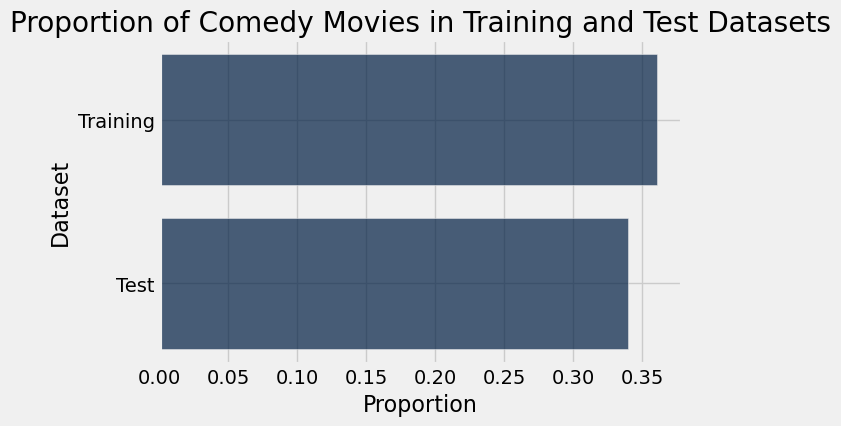

In [28]:
def comedy_proportion(table):
    comedy_count = table.where('Genre', 'comedy').num_rows
    total_movies = table.num_rows
    return comedy_count / total_movies

comedy_table = Table().with_columns(
    'Dataset', make_array('Training', 'Test'),
    'Proportion of Comedy', make_array(comedy_proportion(train_movies), comedy_proportion(test_movies))
)

# Plot a horizontal bar chart
comedy_table.barh('Dataset', 'Proportion of Comedy')
plt.title('Proportion of Comedy Movies in Training and Test Datasets')
plt.xlabel('Proportion')
plt.ylabel('Dataset')
plt.show()

<!-- END QUESTION -->

## 🏘️ Part 2: K-Nearest Neighbors - A Guided Example

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

### Section 2.1: Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram. 

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel". 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

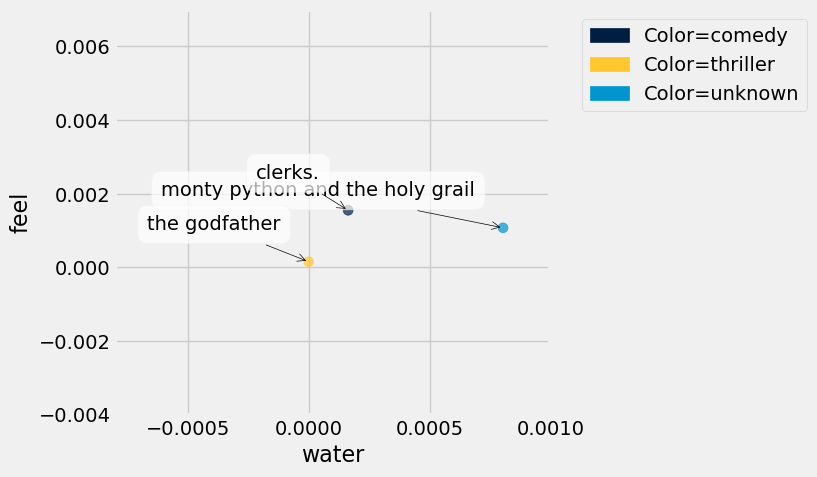

In [29]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plt.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Task 2.1.1 📍

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only.  Assign it the name `one_distance`. 

*Hint 1:* If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint 2:* Refer to the beginning of Part 1 if you don't remember what `row_for_title` does.

*Hint 3:* In the formula for Euclidean distance, think carefully about what `x` and `y` represent. Refer to the example in the text above if you are unsure.

_Points:_ 2

In [ ]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

one_distance = ...
one_distance

In [30]:
python = row_for_title("monty python and the holy grail")
godfather = row_for_title("the godfather")
x1 = python.item("water")
y1 = python.item("feel")
x2 = godfather.item("water")
y2 = godfather.item("feel")

one_distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
one_distance


0.0012225209151294461

In [31]:
grader.check("task_2_1_1")

task_2_1_1 results: All test cases passed!
task_2_1_1 - 1 message: ✅ one_distance is between 0 and 0.01.

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

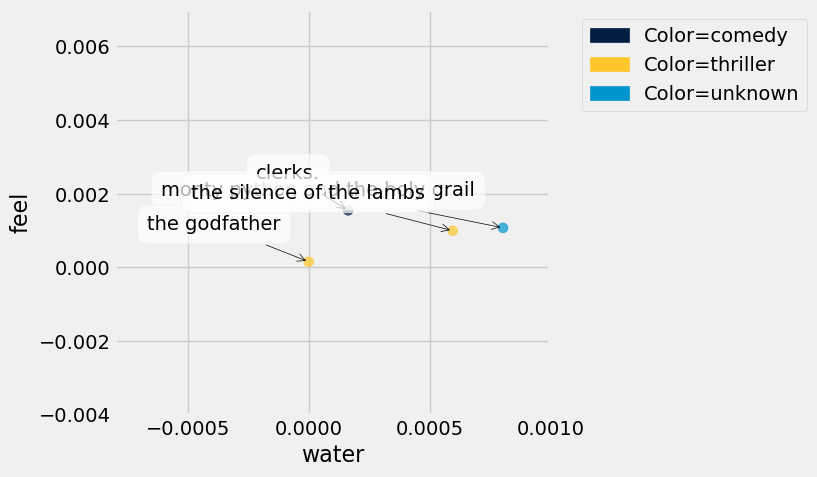

In [32]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plt.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Task 2.1.2 📍

Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

_Points:_ 2

In [ ]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = ...
    row1 = ...
    ...

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

In [33]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    x0 = row0.item(x_feature)
    y0 = row0.item(y_feature)
    
    row1 = row_for_title(title1)
    x1 = row1.item(x_feature)
    y1 = row1.item(y_feature)
    
    distance = ((x1 - x0) ** 2 + (y1 - y0) ** 2) ** 0.5
    return distance

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.000798381068723
the silence of the lambs distance:	 0.000222563148556


In [34]:
grader.check("task_2_1_2")

task_2_1_2 results: All test cases passed!
task_2_1_2 - 1 message: ✅ distance_two_features('clerks.', 'the godfather', 'water', 'feel') returned the correct distance.
task_2_1_2 - 2 message: ✅ distance_two_features('clerks.', 'the godfather', 'your', 'that') returned the correct distance.

#### Task 2.1.3 📍

Define the function `distance_from_python` so that it works as described in its documentation. 

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

_Points:_ 2

In [ ]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    ...

# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

In [35]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    distance = distance_two_features(title, "monty python and the holy grail", "water", "feel")
    return distance

# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.00079838106872277164

In [36]:
grader.check("task_2_1_3")

task_2_1_3 results: All test cases passed!
task_2_1_3 - 1 message: ✅ distance_from_python('clerks.') returned a reasonably correct distance.

#### Task 2.1.4 📍

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To address this task, make a **table** named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `"distance from python"`**.

*Note:* Why are smaller distances from *Monty Python and the Holy Grail* more helpful in helping us classify the movie?

*Hint:* Your final table should only have 5 rows. How can you get the first five rows of a table?

_Points:_ 4

In [ ]:

# The staff solution took multiple lines.
...
close_movies = ...
close_movies

In [37]:
distances = Table().with_columns([
    "Title", train_movies.column("Title"),
    "Genre", train_movies.column("Genre"),
    "water", train_movies.column("water"),
    "feel", train_movies.column("feel"),
    "distance from python", [distance_from_python(movie) for movie in train_movies.column("Title")]
])

distances_sorted = distances.sort("distance from python")

close_movies = distances_sorted.take(np.arange(5))

close_movies


Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


In [38]:
grader.check("task_2_1_4")

task_2_1_4 results: All test cases passed!
task_2_1_4 - 1 message: ✅ close_movies has the correct labels.
task_2_1_4 - 2 message: ✅ close_movies has the correct number of rows.
task_2_1_4 - 3 message: ✅ It seems like you are using the training set.

#### Task 2.1.5 📍

Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below. 

_Points:_ 1

In [ ]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    ...

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

In [39]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    counts = table.group(label)
    
    max_count = max(counts.column("count"))
    most_common_values = counts.where("count", max_count).column(label)
    
    return most_common_values.item(0)

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)


'thriller'

In [40]:
grader.check("task_2_1_5")

task_2_1_5 results: All test cases passed!
task_2_1_5 - 1 message: ✅ most_common worked correctly for our test case.

Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie (unless you count the thrilling holy hand grenade scene). Let's see if we can do better!

## 👋 Submit your Progress Check to Canvas

1. In the related Canvas Assignment page, check the requirements for a Complete score for this checkpoint.
1. Run the following code cell that will run all of the auto-graders tests for the above tasks.
2. Remember that Tasks 1.2.2 and 1.3.1 will need to be manually reviewed.
4. Select the menu items "File", "Save and Export Notebook As...", and "HTML (.html)" in the notebook's Toolbar to download an HTML version of this notebook file.
5. In the related Canvas Assignment page, click Start Assignment or New Attempt to upload the downloaded HTML file.

**Keep in mind that the autograder does not always check for correctness. Sometimes it just checks for the format of your answer, so passing the autograder for a question does not mean you got the answer correct for that question.**

--- 
The cell below will re-run all of the autograder tests for Part 1 and Part 2 to double check your work.

In [41]:
try:
    checkpoint_tests = ["task_1_1", "task_1_1_2", "task_1_1_3", "task_1_1_4",
                        "task_1_2_1", "task_1_2_3", "task_2_1_1", "task_2_1_2",
                        "task_2_1_3", "task_2_1_4", "task_2_1_5"]
    for test in checkpoint_tests:
        display(grader.check(test))
except NameError:
    print('The auto-grader has not be initialized.')

task_1_1 results: All test cases passed!
task_1_1 - 1 message: ✅ expected_row_sum is greater than 0.

task_1_1_2 results: All test cases passed!
task_1_1_2 - 1 message: ✅ most_stem is a string.

task_1_1_3 results: All test cases passed!
task_1_1_3 - 1 message: ✅ longest_uncut is a string.

task_1_1_4 results: All test cases passed!
task_1_1_4 - 1 message: ✅ count_single_stems is an integer.

task_1_2_1 results: All test cases passed!
task_1_2_1 - 1 message: ✅ outer_space_r is between 0.2 and 0.4.

task_1_2_3 results: All test cases passed!
task_1_2_3 - 1 message: ✅ san_francisco is an integer.

task_2_1_1 results: All test cases passed!
task_2_1_1 - 1 message: ✅ one_distance is between 0 and 0.01.

task_2_1_2 results: All test cases passed!
task_2_1_2 - 1 message: ✅ distance_two_features('clerks.', 'the godfather', 'water', 'feel') returned the correct distance.
task_2_1_2 - 2 message: ✅ distance_two_features('clerks.', 'the godfather', 'your', 'that') returned the correct distance.

task_2_1_3 results: All test cases passed!
task_2_1_3 - 1 message: ✅ distance_from_python('clerks.') returned a reasonably correct distance.

task_2_1_4 results: All test cases passed!
task_2_1_4 - 1 message: ✅ close_movies has the correct labels.
task_2_1_4 - 2 message: ✅ close_movies has the correct number of rows.
task_2_1_4 - 3 message: ✅ It seems like you are using the training set.

task_2_1_5 results: All test cases passed!
task_2_1_5 - 1 message: ✅ most_common worked correctly for our test case.

## ✨ Part 3: Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

### Task 3.1 📍

Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length.

Next, use the function you just defined to compute the distance **between the first and second movie** in the **training set** *using all of the features*.  (Remember that the first five columns of your tables are not features.)

*Hint 1:* To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

*Hint 2:* Make sure to drop the first five columns of the table before you compute `distance_first_to_second`, as these columns do not contain any features (the proportions of words). 

_Points:_ 7

In [ ]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    ...

distance_first_to_second = ...
distance_first_to_second

In [ ]:
grader.check("task_3_1")

### Section 3.1: Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is the lack of *computational efficiency* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last task!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average proportion each word occurs in a comedy movie on the horizontal axis and the average proportion it occurs in an thriller movie on the vertical axis. The line graphed is the linear regression line.

The interactive graphing library Plotly Express was used to create the scatter plot. When you have over the graph, a menu bar will appear that allows you to zoom in/out on various parts of the graph using the navigation bar and hover over points to see the word each point represents.

*Note: The line graphed is the line of best fit, NOT the line y=x.*

In [ ]:
# Run this cell to generate the interactive image
words_with_averages = Table().read_table('word_averages.csv')

px.scatter(words_with_averages.to_df(), 
           x="Average Occurence (Comedy)", 
           y="Average Occurence (Thriller)", 
           hover_data=['Word'], 
           trendline="ols",
           trendline_color_override="pink",
           title="Average Occurence (Comedy) vs. Average Occurence (Thriller)")

Tasks 3.1.1 through 3.1.4 will ask you to interpret the plot above. For each task, select one of the following choices and assign its number to the provided name.
1. The word is common in both comedy and thriller movies 
2. The word is uncommon in comedy movies and common in thriller movies
3. The word is common in comedy movies and uncommon in thriller movies
4. The word is uncommon in both comedy and thriller movies
5. It is not possible to say from the plot 

#### Task 3.1.1 📍

What properties do words in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

_Points:_ 2

In [ ]:
bottom_left =

In [ ]:
grader.check("task_3_1_1")

#### Task 3.1.2 📍

What properties do words in the bottom right corner have?

_Points:_ 2

In [ ]:
bottom_right =

In [ ]:
grader.check("task_3_1_2")

#### Task 3.1.3 📍

What properties do words in the top right corner have? 

_Points:_ 2

In [ ]:
top_right =

In [ ]:
grader.check("task_3_1_3")

#### Task 3.1.4 📍

What properties do words in the top left corner have?

_Points:_ 2

In [ ]:
top_left =

In [ ]:
grader.check("task_3_1_4")

#### Task 3.1.5 📍

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the integer corresponding to your answer:
1. It is a thriller movie.
2. It is a comedy movie.

_Points:_ 2

In [ ]:
movie_genre_guess =

In [ ]:
grader.check("task_3_1_5")

#### Task 3.1.6 📍

Using the plot above, make an array of at least 10 common words that you think might let you **distinguish** between comedy and thriller movies. Make sure to choose words that are **frequent enough** that every movie contains at least one of them. Don't just choose the most frequent words though--you can do much better.

_Points:_ 5

In [ ]:
# Set my_features to an array of at least 10 features (strings that are column labels)

my_features = ...

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

In [ ]:
grader.check("task_3_1_6")

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

#### Task 3.1.7 📍🔎

<!-- BEGIN QUESTION -->

In two sentences or less, describe how you selected your features.

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [ ]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [ ]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Task 3.1.8 📍

Use the `fast_distances` function provided above to compute the distance from the first movie in your test set to all the movies in your training set, **using your set of features**. Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

*Hint:* Think about how you can use the variables you defined in 3.1.6.

_Points:_ 4

In [ ]:
# The staff solution took multiple lines of code.
genre_and_distances = ...
genre_and_distances

In [ ]:
grader.check("task_3_1_8")

#### Task 3.1.9 📍

Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

*Hint:* You should use the `most_common` function that was defined earlier.


_Points:_ 2

In [ ]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = ...

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = ...

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

In [ ]:
grader.check("task_3_1_9")

### Section 3.2: A classifier function


Now we can write a single function that encapsulates the whole process of classification.

#### Task 3.2.1 📍

Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. *Hint:* What are the labels of each row in the training set? 
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`). 

_Points:_ 2

In [ ]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = ...
    ...

In [ ]:
grader.check("task_3_2_1")

#### Task 3.2.2 📍

Assign `godzilla_genre` to the genre predicted by your classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features. 

*Hint:* The `row_for_title` function will not work here.

_Points:_ 1

In [ ]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = ...
godzilla_genre = ...
godzilla_genre

In [ ]:
grader.check("task_3_2_2")

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Task 3.2.3 📍

Create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set. 

_Points:_ 1

In [ ]:
def classify_feature_row(row):
    ...

# When you're done, this should produce 'thriller' or 'comedy'.
classify_feature_row(test_my_features.row(0))

In [ ]:
grader.check("task_3_2_3")

### Section 3.3: Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

#### Task 3.3.1 📍

Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  Then, compute the proportion of correct classifications.

*Hint 1*: If you do not specify any columns in `tbl.apply(...)`, your function will be applied to every row object in `tbl`.

*Hint 2*: Which dataset do you want to apply this function to?

_Points:_ 2

In [ ]:
test_guesses = ...
proportion_correct = ...
proportion_correct

In [ ]:
grader.check("task_3_3_1")

#### Task 3.3.2 📍

An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. 

- The `'Genre'` column should contain the original genres, not the ones you predicted. 
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.


_Points:_ 3

In [ ]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
test_movie_correctness = ...
test_movie_correctness.sort('Was correct', descending = True).show(5)

In [ ]:
grader.check("task_3_3_2")

#### Task 3.3.3 📍🔎

<!-- BEGIN QUESTION -->

Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia. 

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for k-NN classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 🔭 Part 4: Explorations
Now that you know how to evaluate a classifier, it's time to build another one.

Your friends are big fans of comedy and thriller movies. They have created their own dataset of movies that they want to watch, but they need your help in determining the genre of each movie in their dataset (comedy or thriller). You have never seen any of the movies in your friends' dataset, so none of your friends' movies are present in your training or test set from earlier. In other words, this new dataset of movies can function as another test set that we are going to make predictions on based on our original training data. 

Run the following cell to load your friends' movie data.

In [ ]:
friend_movies = Table.read_table('friend_movies.csv')
friend_movies.show(5)

### Task 4.1 📍

Your friend's computer is not as powerful as yours, so they tell you that the classifier you create for them can only have up to 5 words as features. Develop a new classifier with the constraint of **using no more than 5 features.** Assign `new_features` to an array of your features.

Your new function should have the same arguments as `classify_feature_row` and return a classification. Name it `another_classifier`. Then, output your accuracy using code from earlier to compare the new classifier to your old one. 

Some ways you can change your classifier are by using different features or trying different values of `k`. (Of course, you still have to use `train_movies` as your training set!)

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous task.

*Note:* There's no one right way to do this! Just make sure that you can explain your reasoning behind the new choices.

_Points:_ 2

In [ ]:
new_features = ...

train_new = train_movies.select(new_features)
test_new = friend_movies.select(new_features)

def another_classifier(row):
    ...

In [ ]:
grader.check("task_4_1")

### Task 4.2 📍🔎

<!-- BEGIN QUESTION -->

Do you see a pattern in the mistakes your new classifier makes? How good an accuracy were you able to get with your limited classifier? Did you notice an improvement from your first classifier to the second one? Describe in two sentences or less. 

*Hint:* You may not be able to see a pattern.

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Task 4.3 📍🔎

<!-- BEGIN QUESTION -->

Given the constraint of five words, how did you select those five? Describe in two sentences or less.

_Points:_ 2

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## 🏁 Submit your Project to Canvas

Once you have finished working on the projects tasks, prepare to submit your work in Canvas by completing the following steps.

1. In the related Canvas Assignment page, check the rubric to know how you will be scored for this assignment.
2. Double-check that you have run the code cell near the end of the notebook that contains the command `"grader.check_all()"`. This command will run all of the run tests on all your responses to the auto-graded tasks marked with 📍.
3. Double-check your responses to the manually graded tasks marked with 📍🔎.
3. Select the menu item "File" and "Save Notebook" in the notebook's Toolbar to save your work and create a specific checkpoint in the notebook's work history.
4. Select the menu items "File", "Download" in the notebook's Toolbar to download the notebook (.ipynb) file. 
5. In the related Canvas Assignment page, click Start Assignment or New Attempt to upload the downloaded .ipynb file.
    * _Keep in mind that if you are working in a group, then you only submit one file for your group._

**Keep in mind that the auto-grader does not always check for correctness. Sometimes it just checks for the format of your answer, so passing the autograder for a question does not mean you got the answer correct for that question.**

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()